In [55]:
import pickle
import numpy as np
import pandas as pd
from manage_db import db_to_df
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
import matplotlib.pyplot as plt
import seaborn as sns
from unidecode import unidecode
from langdetect import detect
%matplotlib inline

In [56]:
# Load data
with open('bestofmc.pickle', 'rb') as f:
    bestdf = pickle.load(f)

df_all = db_to_df()

df_all['post'] = df_all['post'].apply(lambda x: unidecode(x))
bestdf['post'] = bestdf['post'].apply(lambda x: unidecode(x))

In [60]:
def combine_text(df):
    texts = []
    for i in xrange(len(df)):
        text = df.loc[i, 'title'] + ' ' + df.loc[i, 'post']
        texts.append(text)
    return texts

texts = np.concatenate((combine_text(df_all), combine_text(bestdf)))
len(texts)

15009

In [67]:
# keep only english posts
engtexts = np.array([t for t in texts if detect(t) == 'en'])
print 'Number of non-english posts: {} ({:.3f}%)'.format((len(texts)-len(engtexts)), 1.*(len(texts)-len(engtexts))/len(texts))
print len(engtexts)

Number of non-english posts: 77 (0.005%)
14932


In [68]:
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(3, 5))
# vectorizer = TfidfVectorizer(stop_words='english', max_features=5000, ngram_range=(2, 4))
X = vectorizer.fit_transform(engtexts)
feature_words = vectorizer.get_feature_names()
X.shape

(14932, 5000)

In [63]:
rand_inds = np.random.choice(len(engtexts), len(engtexts), replace=False)
increment = 2000
corpus_sizes = range(increment, len(engtexts), increment)
corpus_sizes.append(len(engtexts))
corpus_sizes

[2000, 4000, 6000, 8000, 10000, 12000, 14000, 14928]

In [ ]:
# Explore corpus size
mses = []
for size in corpus_sizes:
    X_ = X[rand_inds[:size]]
    mdl = NMF(n_components=8)
    W = mdl.fit_transform(X_)
    H = mdl.components_
    mse = np.mean(np.square(X_ - W.dot(H)))
    mses.append(mse)
plt.plot(corpus_sizes, mses, label = 'Calculated MSE')
plt.xlabel('Corpus size')

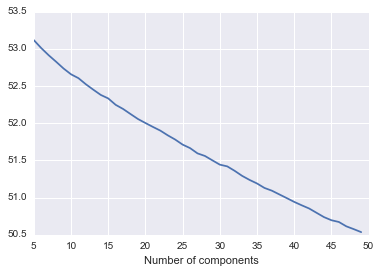

In [65]:
# Explore number of topics
mean_reconstruct_errors = []
mses = []
components = np.arange(5, 50)
for n in components:
    X_ = engX[rand_inds[:3000]]
    mdl = NMF(n_components=n, l1_ratio=1)
    W = mdl.fit_transform(X_)
    H = mdl.components_
    mse = np.mean(np.square(X_ - W.dot(H)))
    mses.append(mse)
    mean_reconstruct_errors.append(mdl.reconstruction_err_)
plt.plot(components, mean_reconstruct_errors, label='NMF reconstruction err')
# plt.plot(components, mses, label = 'Calculated MSE')
plt.xlabel('Number of components')

In [70]:
# Look at top words for each component group
X_ = X[rand_inds[:3000]]
mdl = NMF(n_components=10, l1_ratio=1)
W = mdl.fit_transform(X_)
H = mdl.components_
top_word_inds = np.argsort(H)[:, -10:]
for ind, row in enumerate(top_word_inds):
    print 'Component {}: {}'.format(ind, ', '.join([engfeature_words[i] for i in row]))

Component 0: see this but you, hope you see, hope you read, hope you read this, if you saw, see this but it, you see the, if you remember me, if you remember, you see me
Component 1: like to get, like to get to, like to do, would have to, to go back, to give you my, to give you my number, get to know each other, to let you, get the chance to
Component 2: ran into each, put it out there, put it out, shoot me an email, to do that, not in the, it might be, contact me if you, to do the, it may be
Component 3: would love to hear from, love to hang out, love to have, love to hear, hope to hear back, hope this finds you, hope to hear, hear back from you, to keep my, to introduce myself
Component 4: love to see you, to talk to me, love to see you again, love to buy, would love to chat, would love to meet, love to know, and would love to, and would love to get, would like to talk to
Component 5: am not sure, know this is long shot, know what color, know this is long, this is what, is in or arou

In [49]:
def get_rid_of_end(post):
    phrase = "it's NOT ok to contact this poster with services or other commercial interests"
    post.replace(phrase, '')
    if 'Location: ' in post:
        end_ind = post.index('Location: ')
        post = post[:end_ind]
    if '<!-- ' in post:
        end_ind = post.index('<!-- ')
        post = post[:end_ind]
    return post